<a href="https://colab.research.google.com/github/AnkurMali/IST597_Spring_2022/blob/main/IST597_MLP_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IST597:- Multi-Layer Perceptron

# Case 1: 

Using default batch size without softmax activation in output layer, without any regularization to determine the Categorical Cross-Entropy of test dataset and determine the accuracy of default model in GPU,TPU,CPU and on default mode.

## Load the libraries

In [7]:
import os
import numpy as np
import time
import tensorflow as tf
np.random.seed(6447)
tf.random.set_seed(6447)
from sklearn.metrics import accuracy_score

In [8]:
from sklearn.datasets import fetch_openml
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [9]:
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)
x = (x/255).astype('float32')
y = to_categorical(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [4]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#Get number of Gpu's and id's in the system or else you can also use Nvidia-smi in command prompt.

## Define the input layer size, hidden layers size and output layer size

In [14]:
size_input = 784
size_hidden = [128,64]
size_output = 10
number_of_train_examples = 60000
number_of_test_examples = 10000

In [7]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(4)

## Build MLP using Eager Execution

In [8]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
  def accuracy(self,  y_true, y_pred):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)

    acc = accuracy_score(y_true, y_pred)
    return acc

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

## Train Model

In [9]:
# Set number of epochs
NUM_EPOCHS = 10

In [10]:
# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden, size_output, device='cpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.33996129858193275
Number of Epoch = 1 - Accuracy:= 15.497486787683822
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.33593753282563027
Number of Epoch = 2 - Accuracy:= 15.769741539193802
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.3352567949054622
Number of Epoch = 3 - Accuracy:= 15.682368943671218
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.3434445575105042
Number of Epoch = 4 - Accuracy:= 14.512609145220587
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.34259338891806723
Number of Epoch = 5 - Accuracy:= 14.497484736081933
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.34176956407563025
Number of Epoch = 6 - Accuracy:= 14.537820255055149
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.3393435202205882
Number of Epoch = 7 - Accuracy:= 14.875618557970064
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.3283411567752101
Number of Epoch = 8 - Accuracy:= 15.203350676207982
Number of Epoch = 9 - Catego

In [11]:
# Initialize model using GPU
mlp_on_gpu = MLP(size_input, size_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))


Number of Epoch = 1 - Categorical Cross-Entropy:= 0.3343270745798319
Number of Epoch = 1 - Accuracy:= 8.326127252658875
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.29925649947478994
Number of Epoch = 2 - Accuracy:= 8.6068115234375
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.27727553834033614
Number of Epoch = 3 - Accuracy:= 8.657221433495273
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.25083647912289914
Number of Epoch = 4 - Accuracy:= 8.91771127396271
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.23271229976365546
Number of Epoch = 5 - Accuracy:= 8.971487862723214
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.22044564075630252
Number of Epoch = 6 - Accuracy:= 9.312655921743698
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.2106342568277311
Number of Epoch = 7 - Accuracy:= 9.716005982471113
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.20129098279936974
Number of Epoch = 8 - Accuracy:= 10.233630268513656
Number of Epoch = 9 - Categorical Cr

In [12]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.3374291951155462
Number of Epoch = 1 - Accuracy:= 9.653837316176471
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.2570235031512605
Number of Epoch = 2 - Accuracy:= 9.547950039390757
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.22171481092436976
Number of Epoch = 3 - Accuracy:= 8.791678292410714
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.19523834690126052
Number of Epoch = 4 - Accuracy:= 8.275720420003939
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.17483439469537815
Number of Epoch = 5 - Accuracy:= 7.722778833212973
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.161937631302521
Number of Epoch = 6 - Accuracy:= 7.279084534204307
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.15080337447478992
Number of Epoch = 7 - Accuracy:= 6.911004587381828
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.14032444852941175
Number of Epoch = 8 - Accuracy:= 6.558059820607931
Number of Epoch = 9 - Categorical Cr

In [13]:
#TPU mode
mlp_on_gpu = MLP(size_input, size_hidden, size_output, device='tpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc_total= tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.30038163077731095
Number of Epoch = 1 - Accuracy:= 21.62870929621849
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.2847385110294118
Number of Epoch = 2 - Accuracy:= 38.947971376050425
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.27493421743697477
Number of Epoch = 3 - Accuracy:= 56.26710625656513
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.2707809709821429
Number of Epoch = 4 - Accuracy:= 74.20650603991596
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.2566316964285714
Number of Epoch = 5 - Accuracy:= 92.34892003676471
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.2370674730829832
Number of Epoch = 6 - Accuracy:= 109.42402507878151
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.21712194721638656
Number of Epoch = 7 - Accuracy:= 126.31597131039915
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.2038630842962185
Number of Epoch = 8 - Accuracy:= 143.25379136029412
Number of Epoch = 9 - Categorical

## One Step Inference

In [14]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0002
Test Accuracy: 5.6000


# Case 2

Using default batch size with softmax activation in output layer, without any regularization to determine the Categorical Cross-Entropy of test dataset and determine the accuracy of default model in GPU,TPU,CPU and on default mode.

In [15]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(4)

In [16]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [17]:
# Set number of epochs
NUM_EPOCHS = 10

In [18]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([1], dtype=tf.float32) 
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 6.011259978991597
Number of Epoch = 1 - Accuracy:= 39.78483209690126
Number of Epoch = 2 - Categorical Cross-Entropy:= 2.06938799894958
Number of Epoch = 2 - Accuracy:= 62.03524652048319
Number of Epoch = 3 - Categorical Cross-Entropy:= 1.4493610819327731
Number of Epoch = 3 - Accuracy:= 67.85378643644958
Number of Epoch = 4 - Categorical Cross-Entropy:= 1.1450513392857142
Number of Epoch = 4 - Accuracy:= 70.99331177783613
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.9532591255252101
Number of Epoch = 5 - Accuracy:= 72.81512605042016
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.8170021008403361
Number of Epoch = 6 - Accuracy:= 73.99676667542016
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.7140345982142857
Number of Epoch = 7 - Accuracy:= 74.7663799894958
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.6312430409663865
Number of Epoch = 8 - Accuracy:= 75.2554572610294
Number of Epoch = 9 - Categorical Cross-Entro

In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0012
Test Accuracy: 80.5905


# Case 3

Change Batch Size(HyperParameter Optimization) and try to regularize the objective function by applying Dropout penalty/regularization. Since the codebase is huge because of the model running in different config, I am only going to implement the mlp on default function and not mlp on other modes.

In [19]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(4)

In [20]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.dropout_layer, self.device =\
    size_input, size_hidden, size_output, tf.keras.layers.Dropout(rate=0.2), device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [21]:
# Set number of epochs
NUM_EPOCHS = 10

In [22]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 6.3444506302521
Number of Epoch = 1 - Accuracy:= 40.82018940388655
Number of Epoch = 2 - Categorical Cross-Entropy:= 2.133702993697479
Number of Epoch = 2 - Accuracy:= 62.68072150735294
Number of Epoch = 3 - Categorical Cross-Entropy:= 1.4853623949579833
Number of Epoch = 3 - Accuracy:= 69.37145483193278
Number of Epoch = 4 - Categorical Cross-Entropy:= 1.1803868172268908
Number of Epoch = 4 - Accuracy:= 72.76139870010503
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.9939482668067227
Number of Epoch = 5 - Accuracy:= 74.95306755514706
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.8652255777310924
Number of Epoch = 6 - Accuracy:= 76.41517857142858
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.769320181197479
Number of Epoch = 7 - Accuracy:= 77.43875558035714
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.6934044117647059
Number of Epoch = 8 - Accuracy:= 78.20178735556723
Number of Epoch = 9 - Categorical Cross-Entro

In [23]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0011
Test Accuracy: 79.0286


# Case 4

Change Batch Size(HyperParameter Optimization) and try to regularize the objective function by applying l1 penalty/regularization. Since the codebase is huge because of the model running in different config, I am only going to implement the mlp on default function and not mlp on other modes.

In [24]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(4)

In [25]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      L1= (tf.reduce_sum(self.W1)+ tf.reduce_sum(self.W2)+tf.reduce_sum(self.W3)) # L1 = absolute sum of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) + 0.03 * L1 # Lambda/Regularization Parameter = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    #hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    #hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [26]:
# Set number of epochs
NUM_EPOCHS = 10

In [27]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 6.065636029411765
Number of Epoch = 1 - Accuracy:= 40.7479360884979
Number of Epoch = 2 - Categorical Cross-Entropy:= 2.074591911764706
Number of Epoch = 2 - Accuracy:= 61.2638277967437
Number of Epoch = 3 - Categorical Cross-Entropy:= 1.3941135766806723
Number of Epoch = 3 - Accuracy:= 66.25050059086135
Number of Epoch = 4 - Categorical Cross-Entropy:= 1.0706287421218488
Number of Epoch = 4 - Accuracy:= 68.18159138655462
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.8755820640756302
Number of Epoch = 5 - Accuracy:= 68.76307691045169
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.7420100446428571
Number of Epoch = 6 - Accuracy:= 68.7714638589811
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.6439654017857143
Number of Epoch = 7 - Accuracy:= 68.32946674763656
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.5679954700630252
Number of Epoch = 8 - Accuracy:= 67.92934283088236
Number of Epoch = 9 - Categorical Cross-Entro

In [28]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0008
Test Accuracy: 65.3143


# Case 5

Change Batch Size(HyperParameter Optimization) and try to regularize the objective function by applying l2 penalty/regularization. Since the codebase is huge because of the model running in different config, I am only going to implement the mlp on default function and not mlp on other modes.

In [29]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(4)

In [30]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)))/3 # L2 = (absolute sum of squared weights)/no.of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) + 0.03 * L2 # Lambda/Regularization Parameter = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    #hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    #hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [31]:
# Set number of epochs
NUM_EPOCHS = 10

In [32]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(128)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 1.942091780462185
Number of Epoch = 1 - Accuracy:= 3.0166413122866333
Number of Epoch = 2 - Categorical Cross-Entropy:= 1.0974676339285714
Number of Epoch = 2 - Accuracy:= 5.0409079159007355
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.8253432904411765
Number of Epoch = 3 - Accuracy:= 6.423338817949055
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.6739732799369748
Number of Epoch = 4 - Accuracy:= 7.290558117778362
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.5758572741596638
Number of Epoch = 5 - Accuracy:= 7.937004025242909
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.5062754398634454
Number of Epoch = 6 - Accuracy:= 8.415830467929359
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.4541504398634454
Number of Epoch = 7 - Accuracy:= 8.788086963300945
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.4131860556722689
Number of Epoch = 8 - Accuracy:= 9.097728056066176
Number of Epoch = 9 - Categorical Cross

In [33]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0042
Test Accuracy: 61.5429


# Case 6

Change Batch Size(HyperParameter Optimization) and try to regularize the objective function by applying a combination of l1 and l2 penalty/regularization[Elastic Net Regularization].Dropout regularization from Keras. Since the codebase is huge because of the model running in different config, I am only going to implement the mlp on default function and not mlp on other modes.

In [34]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [35]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      L1= (tf.reduce_sum(self.W1)+ tf.reduce_sum(self.W2)+tf.reduce_sum(self.W3)) # L1 = absolute sum of weights (Also known as Lasso)
      L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)))/3 # L2 = (absolute sum of squared weights)/no.of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) + 0.02*L1 + 0.03 * L2 # Lambda/Regularization Parameter for L1 = 0.02, Lambda/Regularization Parameter for L2 = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
  def accuracy(self,  y_true, y_pred):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true = tf.math.argmax(y_true, axis=-1)
    y_pred = tf.math.argmax(y_pred, axis=-1)

    acc = accuracy_score(y_true, y_pred)
    return acc

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    #hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    #hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [36]:
# Set number of epochs
NUM_EPOCHS = 10

In [37]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc_total= tf.zeros([1], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(128)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))


Number of Epoch = 1 - Categorical Cross-Entropy:= 2.172958508403361
Number of Epoch = 1 - Accuracy:= 11.871858997505253
Number of Epoch = 2 - Categorical Cross-Entropy:= 1.1293400735294117
Number of Epoch = 2 - Accuracy:= 16.56373609013918
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.8094517463235295
Number of Epoch = 3 - Accuracy:= 22.767963826155462
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.6401135766806723
Number of Epoch = 4 - Accuracy:= 29.955843372505253
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.5339504661239496
Number of Epoch = 5 - Accuracy:= 37.82232306985294
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.46077169774159665
Number of Epoch = 6 - Accuracy:= 46.19825860031513
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.40714961922268905
Number of Epoch = 7 - Accuracy:= 54.96629218093487
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.3660302324054622
Number of Epoch = 8 - Accuracy:= 64.05296005120799
Number of Epoch = 9 - Categorical Cr

In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0035
Test Accuracy: 63.4095


# Case 7

Hyper Parameter Optimization for Batch Size using Trial and Error and softmax activation on output


In [60]:
#Let Training Batch Size be 128

# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [61]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      #L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)))/3 # L2 = (absolute sum of squared weights)/no.of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) #+ 0.03 * L2 # Lambda/Regularization Parameter = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    #hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    #hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [62]:
# Set number of epochs
NUM_EPOCHS = 5

In [63]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc_total= tf.zeros([1], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(128)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))


Number of Epoch = 1 - Categorical Cross-Entropy:= 2.205459033613445
Number of Epoch = 1 - Accuracy:= 154.4726726628151
Number of Epoch = 2 - Categorical Cross-Entropy:= 1.117172794117647
Number of Epoch = 2 - Accuracy:= 159.0654050682773
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.7937662815126051
Number of Epoch = 3 - Accuracy:= 165.19216123949582
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.6274538471638655
Number of Epoch = 4 - Accuracy:= 172.3455061712185
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.5263214613970588
Number of Epoch = 5 - Accuracy:= 180.2446494222689

Total time taken (in seconds): 92.87


In [64]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0060
Test Accuracy: 53.1143


In [65]:
#Let Training Batch Size be 15

# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [66]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      #L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)))/3 # L2 = (absolute sum of squared weights)/no.of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) #+ 0.03 * L2 # Lambda/Regularization Parameter = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    #hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    #hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [67]:
# Set number of epochs
NUM_EPOCHS = 10

In [68]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([1], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(15)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 15 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))


Number of Epoch = 1 - Categorical Cross-Entropy:= 7.7892431722689075
Number of Epoch = 1 - Accuracy:= 45.3852969898897
Number of Epoch = 2 - Categorical Cross-Entropy:= 2.490510504201681
Number of Epoch = 2 - Accuracy:= 65.46275316767331
Number of Epoch = 3 - Categorical Cross-Entropy:= 1.7295740546218488
Number of Epoch = 3 - Accuracy:= 70.4496844636292
Number of Epoch = 4 - Categorical Cross-Entropy:= 1.340109768907563
Number of Epoch = 4 - Accuracy:= 73.21394925157563
Number of Epoch = 5 - Categorical Cross-Entropy:= 1.0921659663865546
Number of Epoch = 5 - Accuracy:= 74.72759445575105
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.9167146139705883
Number of Epoch = 6 - Accuracy:= 75.59061515231093
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.7831000525210084
Number of Epoch = 7 - Accuracy:= 76.19811293658088
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.6782192095588235
Number of Epoch = 8 - Accuracy:= 76.69400562959558
Number of Epoch = 9 - Categorical Cross-Entr

In [69]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0007
Test Accuracy: 77.0000


**From these experiments, less training batch size yields good accuracy**

# Case 8

Hyper Parameter Optimization for Learning Rate using Trial and Error

In [70]:
#Let Learning Rate be 1e-3

# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [71]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      #L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)))/3 # L2 = (absolute sum of squared weights)/no.of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) #+ 0.03 * L2 # Lambda/Regularization Parameter = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    #hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    #hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [72]:
# Set number of epochs
NUM_EPOCHS = 10

In [73]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([1], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(10)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))


Number of Epoch = 1 - Categorical Cross-Entropy:= 1.9369612657563025
Number of Epoch = 1 - Accuracy:= 141.13924632352942
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.25762824973739495
Number of Epoch = 2 - Accuracy:= 143.2238543855042
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.13246240644695378
Number of Epoch = 3 - Accuracy:= 139.70772058823528
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.11077118073792017
Number of Epoch = 4 - Accuracy:= 141.7884388130252
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.1012904822085084
Number of Epoch = 5 - Accuracy:= 143.89589351365547
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.09477166491596639
Number of Epoch = 6 - Accuracy:= 146.476825105042
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.08980893021271008
Number of Epoch = 7 - Accuracy:= 149.1692981880252
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.08597659532563025
Number of Epoch = 8 - Accuracy:= 150.67519038865547
Number of Epoch = 9 - Categoric

In [74]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0001
Test Accuracy: 78.4286


In [75]:
#Let Learning Rate be 1e-5

# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [76]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      #L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)))/3 # L2 = (absolute sum of squared weights)/no.of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) #+ 0.03 * L2 # Lambda/Regularization Parameter = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    #hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    #hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [77]:
# Set number of epochs
NUM_EPOCHS = 10

In [78]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([1], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(10)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))


Number of Epoch = 1 - Categorical Cross-Entropy:= 28.626443277310923
Number of Epoch = 1 - Accuracy:= 31.44546431853992
Number of Epoch = 2 - Categorical Cross-Entropy:= 13.09171743697479
Number of Epoch = 2 - Accuracy:= 66.44432362788865
Number of Epoch = 3 - Categorical Cross-Entropy:= 8.95253781512605
Number of Epoch = 3 - Accuracy:= 89.45563616071428
Number of Epoch = 4 - Categorical Cross-Entropy:= 7.062311974789916
Number of Epoch = 4 - Accuracy:= 103.49245010504202
Number of Epoch = 5 - Categorical Cross-Entropy:= 5.9579338235294115
Number of Epoch = 5 - Accuracy:= 112.47080980829831
Number of Epoch = 6 - Categorical Cross-Entropy:= 5.212201680672269
Number of Epoch = 6 - Accuracy:= 118.73659893644958
Number of Epoch = 7 - Categorical Cross-Entropy:= 4.668250525210084
Number of Epoch = 7 - Accuracy:= 123.77844340861344
Number of Epoch = 8 - Categorical Cross-Entropy:= 4.250621060924369
Number of Epoch = 8 - Accuracy:= 127.49289325105042
Number of Epoch = 9 - Categorical Cross-En

In [79]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0035
Test Accuracy: 66.4381


**From these experiments, higher learning rate yields good accuracy**

# Case 9

Hyper Parameter Optimisation for Activation Function using Trial and Error

In [80]:
#Let's use sigmoid

# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [81]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      #L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)))/3 # L2 = (absolute sum of squared weights)/no.of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) #+ 0.03 * L2 # Lambda/Regularization Parameter = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.keras.activations.sigmoid(what1)
    #hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.keras.activations.sigmoid(what2)
    #hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [82]:
# Set number of epochs
NUM_EPOCHS = 10

In [83]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([1], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))


Number of Epoch = 1 - Categorical Cross-Entropy:= 0.8955722163865546
Number of Epoch = 1 - Accuracy:= 18.114620946034666
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.8675361081932773
Number of Epoch = 2 - Accuracy:= 18.33645245207458
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.8410790441176471
Number of Epoch = 3 - Accuracy:= 18.538131072741596
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.8158172268907563
Number of Epoch = 4 - Accuracy:= 18.770037995667018
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.7914929096638655
Number of Epoch = 5 - Accuracy:= 18.93807239692752
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.7679376969537816
Number of Epoch = 6 - Accuracy:= 18.995191045168067
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.7450797006302521
Number of Epoch = 7 - Accuracy:= 19.173350101759453
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.7228803177521008
Number of Epoch = 8 - Accuracy:= 19.217061531643907
Number of Epoch = 9 - Categorical 

In [84]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0006
Test Accuracy: 9.1810


In [85]:
#Let's use tanh
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [86]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      #L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)))/3 # L2 = (absolute sum of squared weights)/no.of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) #+ 0.03 * L2 # Lambda/Regularization Parameter = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.tanh(what1)
    #hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.tanh(what2)
    #hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [87]:
# Set number of epochs
NUM_EPOCHS = 10

In [88]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([1], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(10)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 1.1139016544117648
Number of Epoch = 1 - Accuracy:= 19.408633961397058
Number of Epoch = 2 - Categorical Cross-Entropy:= 1.084982668067227
Number of Epoch = 2 - Accuracy:= 19.842213350183822
Number of Epoch = 3 - Categorical Cross-Entropy:= 1.057905724789916
Number of Epoch = 3 - Accuracy:= 20.373229467568276
Number of Epoch = 4 - Categorical Cross-Entropy:= 1.0325221901260504
Number of Epoch = 4 - Accuracy:= 20.877420890231093
Number of Epoch = 5 - Categorical Cross-Entropy:= 1.0087566964285715
Number of Epoch = 5 - Accuracy:= 21.512703518907564
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.9865191701680672
Number of Epoch = 6 - Accuracy:= 22.171505711659663
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.9657086397058824
Number of Epoch = 7 - Accuracy:= 22.90763072807248
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.9462326024159664
Number of Epoch = 8 - Accuracy:= 23.63018644957983
Number of Epoch = 9 - Categorical Cr

In [89]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0009
Test Accuracy: 12.9333


# Case 10

Hyper Parameter Optimisation for Optimizer using Trial and Error

In [90]:
#Let's use Adagrad
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [91]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=1e-5)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      #L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)))/3 # L2 = (absolute sum of squared weights)/no.of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) #+ 0.03 * L2 # Lambda/Regularization Parameter = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.tanh(what1)
    #hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.tanh(what2)
    #hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [92]:
# Set number of epochs
NUM_EPOCHS = 10

In [93]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([1], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 1.2349779411764705
Number of Epoch = 1 - Accuracy:= 16.047468938747375
Number of Epoch = 2 - Categorical Cross-Entropy:= 1.1713983718487395
Number of Epoch = 2 - Accuracy:= 17.18701171875
Number of Epoch = 3 - Categorical Cross-Entropy:= 1.1149443277310924
Number of Epoch = 3 - Accuracy:= 18.34651761095063
Number of Epoch = 4 - Categorical Cross-Entropy:= 1.064200892857143
Number of Epoch = 4 - Accuracy:= 19.697688254989494
Number of Epoch = 5 - Categorical Cross-Entropy:= 1.0179168198529411
Number of Epoch = 5 - Accuracy:= 21.240414915966387
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.9754972426470588
Number of Epoch = 6 - Accuracy:= 22.813439633665965
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.936459887079832
Number of Epoch = 7 - Accuracy:= 24.591552734375
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.900398568802521
Number of Epoch = 8 - Accuracy:= 26.21500582654937
Number of Epoch = 9 - Categorical Cross-Entr

In [94]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0008
Test Accuracy: 15.3810


In [95]:
#Let's use Adam
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [96]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      #L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)))/3 # L2 = (absolute sum of squared weights)/no.of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) #+ 0.03 * L2 # Lambda/Regularization Parameter = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.tanh(what1)
    #hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.tanh(what2)
    #hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [97]:
# Set number of epochs
NUM_EPOCHS = 10

In [99]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  acc= tf.zeros([1], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs) 
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    preds = tf.cast(preds, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
    acc = acc + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
  time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.5797515756302521
Number of Epoch = 1 - Accuracy:= 10.479032628676471
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.5213774947478992
Number of Epoch = 2 - Accuracy:= 12.003362575498949
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.47157648371848737
Number of Epoch = 3 - Accuracy:= 13.731080127363446
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.42868973214285716
Number of Epoch = 4 - Accuracy:= 15.601668157497372
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.391703518907563
Number of Epoch = 5 - Accuracy:= 17.73784631039916
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.35937414653361344
Number of Epoch = 6 - Accuracy:= 20.327753660057773
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.3313203125
Number of Epoch = 7 - Accuracy:= 23.048762473739494
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.30696494222689075
Number of Epoch = 8 - Accuracy:= 25.798329585740547
Number of Epoch = 9 - Categorical Cr

In [100]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
yTrueMax = np.array([maxposition(rec) for rec in y_test])
yPredMax = np.array([maxposition(rec) for rec in preds])
val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Test Categorical entropy loss: 0.0005
Test Accuracy: 31.5048


# Case 11

Calling the most optimal function 10 times and plotting the accuracy for each time: Optimal model has Dropout layer Regularization, Batch size = 20, Activation Fn = Relu, Optimizer = SGD, Learning Rate = 1e-4.

In [10]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [11]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.dropout_layer, self.device =\
    size_input, size_hidden, size_output, tf.keras.layers.Dropout(rate=0.2), device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [12]:
# Set number of epochs
NUM_EPOCHS = 4

In [15]:
#Default mode
def train():
  mlp_on_default = MLP(size_input, size_hidden, size_output)

  time_start = time.time()
  for epoch in range(NUM_EPOCHS):
    loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
    lt = 0
    acc= tf.zeros([1], dtype=tf.float32)
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(6447)).batch(20)
    for inputs, outputs in train_ds:
      preds = mlp_on_default.forward(inputs) 
      outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
      preds = tf.cast(preds, dtype=tf.float32)
      accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(preds, 1)), "float"))
      acc = acc + accuracy
      loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
      lt = lt + mlp_on_default.loss(preds, outputs)
      mlp_on_default.backward(inputs, outputs)
    print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
    print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(acc) * 20 / x_train.shape[0])*100))
    time_taken = time.time() - time_start

  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 5.446060399159664
Number of Epoch = 1 - Accuracy:= 44.3277269892332
Number of Epoch = 2 - Categorical Cross-Entropy:= 1.962219800420168
Number of Epoch = 2 - Accuracy:= 64.87734292935924
Number of Epoch = 3 - Categorical Cross-Entropy:= 1.4054157037815127
Number of Epoch = 3 - Accuracy:= 70.32942161239497
Number of Epoch = 4 - Categorical Cross-Entropy:= 1.1238029149159663
Number of Epoch = 4 - Accuracy:= 73.17142364758404

Total time taken (in seconds): 316.38


In [109]:
accuracy_list =[]
for i in range(0,9):
  train()
  test_loss_total = tf.Variable(0, dtype=tf.float32)
  preds = mlp_on_default.forward(x_test)
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, y_test)

  print('Test Categorical entropy loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_test.shape[0]))


  maxposition = lambda x : np.argmax(x)
  # List comprehension to map the lambda function across all records of yTrue and yPred
  yTrueMax = np.array([maxposition(rec) for rec in y_test])
  yPredMax = np.array([maxposition(rec) for rec in preds])
  val_acc = sum(yPredMax == yTrueMax)/len(yPredMax)
  accuracy_list.append(val_acc)
  print('Test Accuracy: {:.4f}'.format(val_acc*100,"%"))

Number of Epoch = 1 - Categorical Cross-Entropy:= 6.017623949579832
Number of Epoch = 1 - Accuracy:= 38.47900800945378
Number of Epoch = 2 - Categorical Cross-Entropy:= 2.0433325892857144
Number of Epoch = 2 - Accuracy:= 59.853831571691174
Number of Epoch = 3 - Categorical Cross-Entropy:= 1.4000345325630252
Number of Epoch = 3 - Accuracy:= 65.87394957983193
Number of Epoch = 4 - Categorical Cross-Entropy:= 1.0891465992647058
Number of Epoch = 4 - Accuracy:= 68.92772616859244

Total time taken (in seconds): 403.43
Test Categorical entropy loss: 0.0010
Test Accuracy: 77.5714
Number of Epoch = 1 - Categorical Cross-Entropy:= 6.6460703781512604
Number of Epoch = 1 - Accuracy:= 40.15635668329832
Number of Epoch = 2 - Categorical Cross-Entropy:= 2.010510898109244
Number of Epoch = 2 - Accuracy:= 61.9461331407563
Number of Epoch = 3 - Categorical Cross-Entropy:= 1.3464889705882352
Number of Epoch = 3 - Accuracy:= 68.49747242647058
Number of Epoch = 4 - Categorical Cross-Entropy:= 1.0419036896

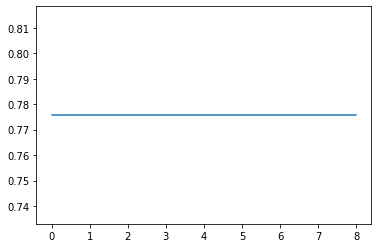

In [110]:
from matplotlib import pyplot as plt
plt.plot(accuracy_list)


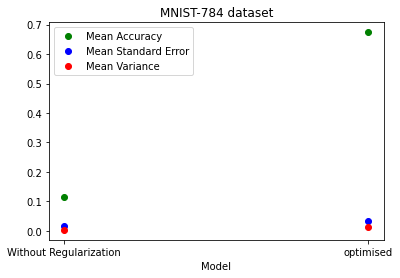

In [25]:
import numpy as np
import matplotlib.pyplot as plt

accuracy_base = np.array([11.50, 17.44, 17.81, 12.41, 5.20, 4.70, 6.86, 19.25, 5.44, 15.56])/100.0
mean_base = np.sum(accuracy_base)/accuracy_base.shape[0]
standard_dev_base = np.sqrt(np.sum((accuracy_base-mean_base)**2)/(accuracy_base.shape[0]-1.0))
standard_error_base = standard_dev_base/np.sqrt(accuracy_base.shape[0])
variance_base = standard_dev_base**2


accuracy_optimised = np.array([44.52, 67.95, 78.26, 54.46, 62.47, 75.63, 67.30, 69.49, 75.33, 78.54])/100.0
mean_optimised = np.sum(accuracy_optimised)/accuracy_optimised.shape[0]
standard_dev_optimised = np.sqrt(np.sum((accuracy_optimised-mean_optimised)**2)/(accuracy_optimised.shape[0]-1.0))
standard_error_optimised = standard_dev_optimised/np.sqrt(accuracy_optimised.shape[0])
variance_optimised = standard_dev_optimised**2

x = np.array([0,1])
y_mean = np.array([mean_base, mean_optimised])
y_standard_error = np.array([standard_error_base, standard_error_optimised])
y_variance = np.array([variance_base, variance_optimised])


plt.figure(0)
my_xticks = ['Without Regularization','optimised']
plt.plot(x, y_mean, 'go', label='Mean Accuracy')
plt.plot(x, y_standard_error, 'bo', label='Mean Standard Error')
plt.plot(x, y_variance, 'ro', label='Mean Variance')
plt.xticks(x, my_xticks)
plt.xlabel('Model')
plt.title('MNIST-784 dataset')
plt.legend()
plt.savefig('MNIST_plots.jpg',dpi=200)

In [19]:
%pip install mlxtend --upgrade

In [23]:
from mlxtend.evaluate import bias_variance_decomp
mse, bias, var = bias_variance_decomp(mlp_on_default, x_train, y_train, x_test, y_test, loss='mse', num_rounds=200, random_seed=1)

TypeError: ignored